In [26]:
#ignore all warnings
import warnings
warnings.filterwarnings(action='ignore')

#importing libraries
import tensorflow as tf
import tensorflow_hub as hub
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib as mpl

from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline as PP
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score, f1_score, recall_score, precision_score

In [18]:
pip install tensorflow_hub

Defaulting to user installation because normal site-packages is not writeable
     -------------------------------------- 90.3/90.3 kB 165.3 kB/s eta 0:00:00
Note: you may need to restart the kernel to use updated packages.


In [2]:
train_df = pd.read_csv('train.csv')
train_df.head()

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1


In [3]:
test_df = pd.read_csv('test.csv')
test_df.head()

,id,keyword,location,text
0,0,NaN,NaN,Just happened a terrible car crash
1,2,NaN,NaN,"Heard about #earthquake is different cities, s..."
2,3,NaN,NaN,"there is a forest fire at spot pond, geese are..."
3,9,NaN,NaN,Apocalypse lighting. #Spokane #wildfires
4,11,NaN,NaN,Typhoon Soudelor kills 28 in China and Taiwan


In [4]:
train_df.shape

(7613, 5)

In [5]:
#we are gonna work on training data so lets's get split it to the training and validation set
train_sentences,val_sentences,train_labels,val_labels = train_test_split(train_df['text'].to_numpy(),
                                                                         train_df['target'].to_numpy(),
                                                                         test_size= 0.2, # 20% of data gonna be used for testing
                                                                         random_state= 42)

# Converting text to numbers
There are 2 ways to turn text to numbers
1. Tokenization
* Word-Level Tokenization
* Character Level Tokenization
* Sub-Word Tokenization
2. Embedding
* Use ( sucs as tf.keras.layers.Embedding) to create new Embedding
* Or use pre-learned Embedding

In [6]:
#let's create text vectorizer
text_vectorizer = tf.keras.layers.TextVectorization(max_tokens=None,
                                                    standardize='lower_and_strip_punctuation',
                                                    split='whitespace',
                                                    ngrams=None,
                                                    output_mode='int',
                                                    output_sequence_length=None,
                                                    pad_to_max_tokens=False)

In [7]:
#fit the text vectorizer to the train sentences
text_vectorizer.adapt(train_sentences)

In [8]:
sample_sentence = train_sentences[0]
sample_sentence, text_vectorizer([sample_sentence])

('Courageous and honest analysis of need to use Atomic Bomb in 1945. #Hiroshima70 Japanese military refused surrender. https://t.co/VhmtyTptGR',
 <tf.Tensor: shape=(1, 18), dtype=int64, numpy=
 array([[17198,     8,  4962,  2917,     6,   156,     5,   438,   216,
           118,     4,  2377,  4973,  1177,   240,  4381,  4119, 14803]],
       dtype=int64)>)

# It is time to build a model and specifically, we'll be building the following:

- Model 0: Naive Bayes (baseline)
- Model 1: Feed-forward neural network (dense model)
- Model 2: LSTM model
- Model 3: GRU model
- Model 4: Bidirectional-LSTM model
- Model 5: 1D Convolutional Neural Network
- Model 6: TensorFlow Hub Pretrained Feature Extractor
- Model 7: Same as model 6 with 10% of training data

# Model 0: Baseline Model

In [9]:
#create the model
model_0 = PP(steps=[
    ('tdf', TfidfVectorizer()), #convert text to numbers using tfidfvectorizer
    ('clf', MultinomialNB())    #model the text
])

#fit the model
model_0.fit(train_sentences,train_labels)

Pipeline(steps=[('tdf', TfidfVectorizer()), ('clf', MultinomialNB())])

In [10]:
#let's look at the score
model_0_score = model_0.score(val_sentences,val_labels)
print(f'The Accuracy Score of Baseline model is {round(model_0_score * 100,2)}%')

The Accuracy Score of Baseline model is 79.97%


In [11]:
model_0_predictions = model_0.predict(val_sentences)

In [12]:
#let's create function to see our model all results (accuracy, presicion,f1, recall)
def calculate_metrics(y_true, y_pred):
    model_results = { 
        'accuracy': round(accuracy_score(y_true,y_pred),2),
        'recall': round(recall_score(y_true,y_pred),2),
        'precision': round(precision_score(y_true,y_pred),2),
        'f1_score': round(f1_score(y_true,y_pred)*100,2),
    }
    return model_results

In [13]:
calculate_metrics(val_labels, model_0_predictions)

{'accuracy': 0.8, 'recall': 0.63, 'precision': 0.86, 'f1_score': 72.84}

# Model 1: Simple Dense Model

In [33]:
#create the model
embedding = "https://tfhub.dev/google/nnlm-en-dim50/2"
hub_layer = hub.KerasLayer(embedding,
                           input_shape = [],
                           dtype = tf.string,
                           trainable = True)

model_1 = tf.keras.models.Sequential([
    hub_layer,
    tf.keras.layers.Dense(16, activation='relu'),
    tf.keras.layers.Dense(1)
])


#compile the model
model_1.compile(loss = tf.keras.losses.BinaryCrossentropy(from_logits=True),
               optimizer = tf.keras.optimizers.Adam(learning_rate = 0.01),
               metrics = ['accuracy'])

#fit the model
model_1_history = model_1.fit(train_sentences,
                              train_labels,
                              batch_size = 512,
                              epochs= 10,
                              validation_data=(val_sentences,val_labels))


Epoch 1/10
12/12 [==============================] - 10s 726ms/step - loss: 0.5868 - accuracy: 0.6023 - val_loss: 0.4993 - val_accuracy: 0.7787
Epoch 2/10
12/12 [==============================] - 8s 645ms/step - loss: 0.3124 - accuracy: 0.8691 - val_loss: 0.5262 - val_accuracy: 0.7958
Epoch 3/10
12/12 [==============================] - 8s 636ms/step - loss: 0.1228 - accuracy: 0.9545 - val_loss: 0.7060 - val_accuracy: 0.7794
Epoch 4/10
12/12 [==============================] - 8s 636ms/step - loss: 0.0527 - accuracy: 0.9813 - val_loss: 0.8878 - val_accuracy: 0.7715
Epoch 5/10
12/12 [==============================] - 8s 641ms/step - loss: 0.0280 - accuracy: 0.9890 - val_loss: 1.0279 - val_accuracy: 0.7656
Epoch 6/10
12/12 [==============================] - 8s 654ms/step - loss: 0.0215 - accuracy: 0.9926 - val_loss: 1.0758 - val_accuracy: 0.7610
Epoch 7/10
12/12 [==============================] - 8s 645ms/step - loss: 0.0164 - accuracy: 0.9934 - val_loss: 1.1308 - val_accuracy: 0.7669
Epoch

<Figure size 1600x900 with 0 Axes>

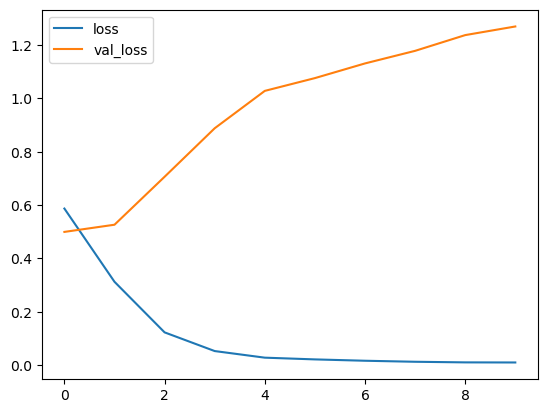

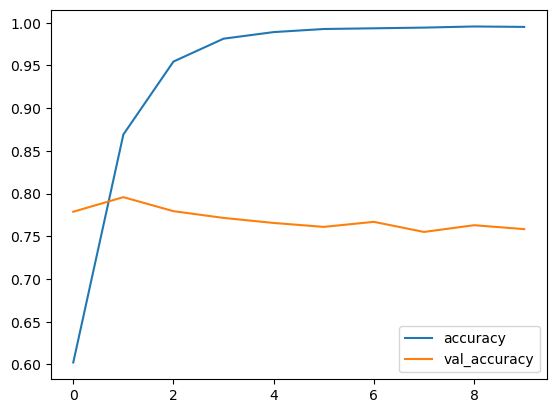

In [54]:
plt.figure(figsize=(16,9))
pd.DataFrame(model_1_history.history)[['loss','val_loss']].plot()
pd.DataFrame(model_1_history.history)[['accuracy','val_accuracy']].plot()
plt.show()

In [57]:
val_sentences,val_labels

(array(['So you have a new weapon that can cause un-imaginable destruction.',
        'The f$&amp;@ing things I do for #GISHWHES Just got soaked in a deluge going for pads and tampons. Thx @mishacollins @/@',
        'DT @georgegalloway: RT @Galloway4Mayor: \x89ÛÏThe CoL police can catch a pickpocket in Liverpool Stree... http://t.co/vXIn1gOq4Q',
        ...,
        'Man charged over fatal crash near Dubbo refused bail http://t.co/HDBMfOVUtZ via @dailyliberal',
        '#usNWSgov Severe Weather Statement issued August 05 at 10:38PM EDT by NWS: ...THE SEVERE THUNDERSTORM WARNING ... http://t.co/7HuEN4rWrn',
        "Great British &lt;b&gt;Bake&lt;/b&gt; Off's back and Dorret's &lt;b&gt;chocolate&lt;/b&gt; gateau collapsed - JAN\x89Û_ http://t.co/53LORsrGqf"],
       dtype=object),
 array([1, 0, 1, ..., 1, 1, 0], dtype=int64))

In [59]:
predictions_1 = model_1.predict(val_sentences)

48/48 [==============================] - 4s 73ms/step


In [61]:
predictions_1[:10]

array([[-9.545934  ],
       [-1.2043769 ],
       [-0.37403542],
       [-6.273798  ],
       [-3.8244    ],
       [-8.742268  ],
       [-9.660279  ],
       [-8.746992  ],
       [-0.873086  ],
       [ 9.354178  ]], dtype=float32)

In [65]:
model_1.predict(val_sentences[:10])

1/1 [==============================] - 0s 108ms/step


array([[-9.545934  ],
       [-1.2043769 ],
       [-0.37403542],
       [-6.273798  ],
       [-3.8244    ],
       [-8.742268  ],
       [-9.660279  ],
       [-8.746992  ],
       [-0.873086  ],
       [ 9.354178  ]], dtype=float32)

In [64]:
val_sentences[1]

'The f$&amp;@ing things I do for #GISHWHES Just got soaked in a deluge going for pads and tampons. Thx @mishacollins @/@'